C:\Users\awwalola\AppData\Local\Temp\ipykernel_35792\3180347898.py:62: OptimizeWarning: Unknown solver options: maxfun
  result = minimize(loss_function, initial_params, args=(X_train, Y_train),


Optimization terminated successfully.
         Current function value: 263034494.690331
         Iterations: 49
         Function evaluations: 173127


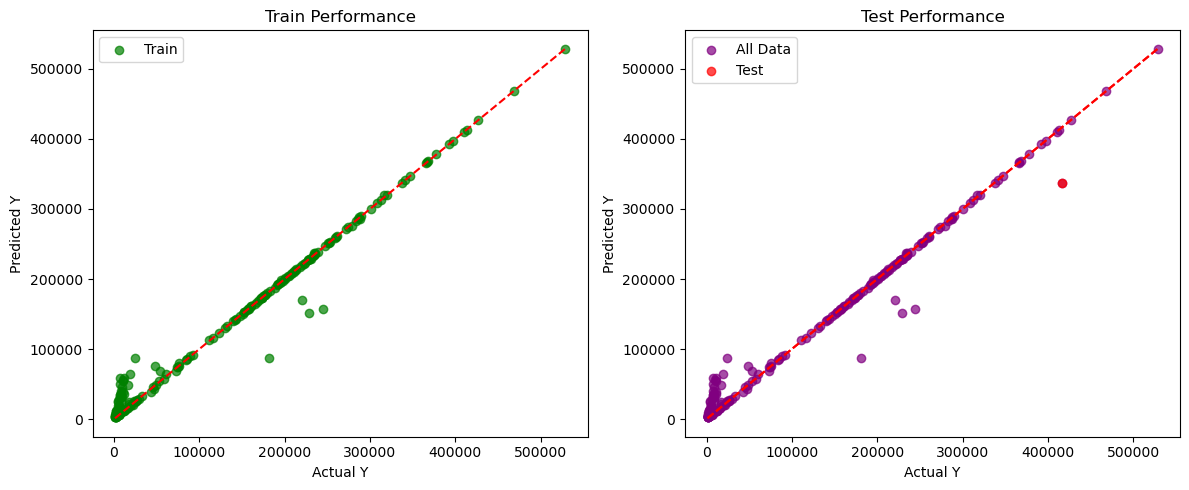

Predicted Y for new input: 979122.5351567023


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

# ========================
# Custom Model Equation and Loss Function
# ========================
def custom_model_equation(X, params):
    """
    Computes the predicted Y using the custom equation.
    
    Parameters:
      - X: array with shape (n_samples, 10); features in order:
           [Dia, Dev(deg), Area (m2), z, GasDens, LiquidDens, g (m/s2), P/T, friction_factor, critical_film_thickness]
      - params: array-like parameters where the first 5 values are global parameters (p1-p5)
                and the remaining values correspond to α (one per sample or predicted sample)
                
    Returns:
      - Y_pred: predicted Y values (array)
    """
    Dia, Dev_deg, Area_m2, z, GasDens, LiquidDens, g_m_s2, P_T, friction_factor, critical_film_thickness = X.T

    # Guard against division errors
    z = np.maximum(z, 1e-8)
    GasDens = np.maximum(GasDens, 1e-8)
    friction_factor = np.maximum(friction_factor, 1e-8)
    critical_film_thickness = np.maximum(critical_film_thickness, 1e-8)

    p1, p2, p3, p4, p5 = params[:5]
    alpha = params[5:]

    term1 = (2 * g_m_s2 * Dia * (1 - 3 * (Dia / critical_film_thickness) +
             3 * ((Dia / critical_film_thickness) ** 2)) *
             (LiquidDens - GasDens) * np.cos(Dev_deg) /
             (friction_factor * GasDens)) * p4

    term2 = np.abs(np.sin(p5 * Dev_deg)) ** p3 * ((LiquidDens - GasDens) ** p2 / (GasDens ** 2))

    Y_pred = p1 * np.sqrt(np.abs((term1 * alpha + (1 - alpha) * term2)) * ((1 / z) * (P_T)))
    return Y_pred/1000

def loss_function(params, X, Y):
    Y_pred = custom_model_equation(X, params)
    return np.mean((Y - Y_pred) ** 2)

# ========================
# Parameter Learning (Training)
# ========================
def learn_parameters(X_train, Y_train):
    """
    Learns the model parameters (p1-p5 and one α per training sample) by minimizing the loss.
    
    Returns:
       - learned_params: concatenated array with p1-p5 and training α values.
    """
    n_train = len(Y_train)
    initial_params = np.concatenate(([1.0, 1.0, 0.5, 1.0, 1.0], np.full(n_train, 0.5)))
    bounds = [(None, None)] * 5 + [(0, 1)] * n_train

    result = minimize(loss_function, initial_params, args=(X_train, Y_train),
                      bounds=bounds, method="Powell",
                      options={'maxiter': 5000, 'maxfun': 10000, 'disp': True})
    if result.success:
        return result.x
    else:
        raise RuntimeError("Optimization failed: " + result.message)

# ========================
# Enhanced Dev-based Alpha Matching Function
# ========================
def predict_y(X_new, learned_params, dev_train, X_train,
              alpha_strategy='enhanced_dev_based', multiple_dev_policy='max',
              dev_tol=1e-3, feature_tol=1.0):
    """
    Predicts Y for new input samples using learned parameters and an enhanced dev-based α assignment.
    
    Parameters:
      - X_new: New data array (n_samples, 10)
      - learned_params: Array containing p1-p5 and training α (length 5 + len(X_train))
      - dev_train: The Dev(deg) values from training data (array)
      - X_train: The full training feature array (needed for full-feature matching)
      - alpha_strategy: Must be 'enhanced_dev_based' in this implementation.
      - multiple_dev_policy: Policy to choose among multiple matching training samples when dev < 20
          (e.g., 'max', 'min', 'mean', or 'median')
      - dev_tol: Tolerance for matching Dev(deg) values.
      - feature_tol: Threshold distance for full-feature matching when Dev(deg) >= 30.
    
    For each new sample:
        - If Dev(deg) < 20:
            Uses regular dev-based matching: find training samples with similar Dev(deg)
            and, if multiple are found, applies the given policy.
        - If 20 <= Dev(deg) < 30:
            Uses training α from matching samples (within dev_tol) but selects the minimum α.
        - If Dev(deg) >= 30:
            Computes the Euclidean distance between the new sample and every training sample.
            If the closest distance is below feature_tol, uses that training sample's α;
            otherwise, falls back to the global mean of training α.
    
    Returns:
      - Y_pred: Predicted Y values (array)
    """
    p_opt = learned_params[:5]
    alpha_train = learned_params[5:]
    alpha_used = []

    for i in range(len(X_new)):
        d_new = X_new[i, 1]  # Dev(deg) of new sample

        if d_new < 10:
            # For dev < 20: use matching based on Dev(deg) with specified policy
            match_idx = np.where(np.abs(dev_train - d_new) <= dev_tol)[0]
            if len(match_idx) == 0:
                alpha_used.append(np.mean(alpha_train))
            elif len(match_idx) == 1:
                alpha_used.append(alpha_train[match_idx[0]])
            else:
                alphas = alpha_train[match_idx]
                if multiple_dev_policy == 'max':
                    alpha_used.append(np.max(alphas))
                elif multiple_dev_policy == 'min':
                    alpha_used.append(np.min(alphas))
                elif multiple_dev_policy == 'mean':
                    alpha_used.append(np.mean(alphas))
                elif multiple_dev_policy == 'median':
                    alpha_used.append(np.median(alphas))
                else:
                    raise ValueError("Invalid multiple_dev_policy.")
        elif 10 <= d_new < 20:
            # For 20 <= dev < 30: use the minimum α among matching samples
            match_idx = np.where(np.abs(dev_train - d_new) <= dev_tol)[0]
            if len(match_idx) == 0:
                alpha_used.append(np.mean(alpha_train))
            else:
                alphas = alpha_train[match_idx]
                alpha_used.append(np.min(alphas))
        else:  # d_new >= 30
            # For dev >= 30: use full-feature matching
            distances = np.linalg.norm(X_train - X_new[i, :], axis=1)
            min_dist = np.min(distances)
            if min_dist < feature_tol:
                closest_idx = np.argmin(distances)
                alpha_used.append(alpha_train[closest_idx])
            else:
                alpha_used.append(np.mean(alpha_train))
    alpha_used = np.array(alpha_used)
    full_params = np.concatenate((p_opt, alpha_used))
    return custom_model_equation(X_new, full_params)

# ========================
# Main Script
# ========================
if __name__ == "__main__":
    # Load dataset
    df = pd.read_csv(r'C:\Users\awwalola\Downloads\processed_well_data.csv')
    X = df[['Dia', 'Dev(deg)', 'Area (m2)', 'z', 'GasDens', 'LiquidDens', 'g (m/s2)', 'P/T', 'friction_factor', 'critical_film_thickness']].values
    Y = df["Qcr"].values

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.00000000001, random_state=42)
    
    # Learn parameters from the training data
    opt_params = learn_parameters(X_train, Y_train)
    p_opt = opt_params[:5]
    alpha_train = opt_params[5:]
    dev_train = X_train[:, 1]  # Dev(deg) from training samples

    # Define the multiple_dev_policy variable
    multiple_dev_policy = 'max'  # You can change this to 'min', 'mean', or 'median' as needed
    
    # Predict on training set using the enhanced dev-based matching
    Y_train_pred = predict_y(X_train, opt_params, dev_train, X_train,
                             alpha_strategy='enhanced_dev_based',
                             multiple_dev_policy=multiple_dev_policy,
                             dev_tol=1e-3, feature_tol=1.0)
    
    # Predict on test set using the same enhanced dev-based matching
    Y_test_pred = predict_y(X_test, opt_params, dev_train, X_train,
                            alpha_strategy='enhanced_dev_based',
                            multiple_dev_policy=multiple_dev_policy,
                            dev_tol=1e-3, feature_tol=1.0)
    
    # Combined prediction on the full dataset
    Y_all_pred = predict_y(X, opt_params, dev_train, X_train,
                           alpha_strategy='enhanced_dev_based',
                           multiple_dev_policy=multiple_dev_policy,
                           dev_tol=1e-3, feature_tol=1.0)
    
    # Plot Training and Combined Performance
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(Y_train, Y_train_pred, label='Train', color='green', alpha=0.7)
    plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--')
    plt.xlabel("Actual Y")
    plt.ylabel("Predicted Y")
    plt.title("Train Performance")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(Y, Y_all_pred, label='All Data', color='purple', alpha=0.7)
    plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--')
    plt.xlabel("Actual Y")
    plt.ylabel("Predicted Y")
    plt.title("Combined Performance")
    plt.legend()
    
  
    plt.scatter(Y_test, Y_test_pred, label='Test', color='red', alpha=0.7)
    plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--')
    plt.xlabel("Actual Y")
    plt.ylabel("Predicted Y")
    plt.title("Test Performance")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Example: Predict for a new X input using the enhanced dev-based strategy
    X_example = np.array([[0.3, 45.0, 0.01, 1000, 20, 800, 9.81, 1.2, 0.005, 0.0005]])
    Y_example_pred = predict_y(X_example, opt_params, dev_train, X_train,
                               alpha_strategy='enhanced_dev_based',
                               multiple_dev_policy=multiple_dev_policy,
                               dev_tol=1e-3, feature_tol=1.0)
    print("Predicted Y for new input:", Y_example_pred[0])

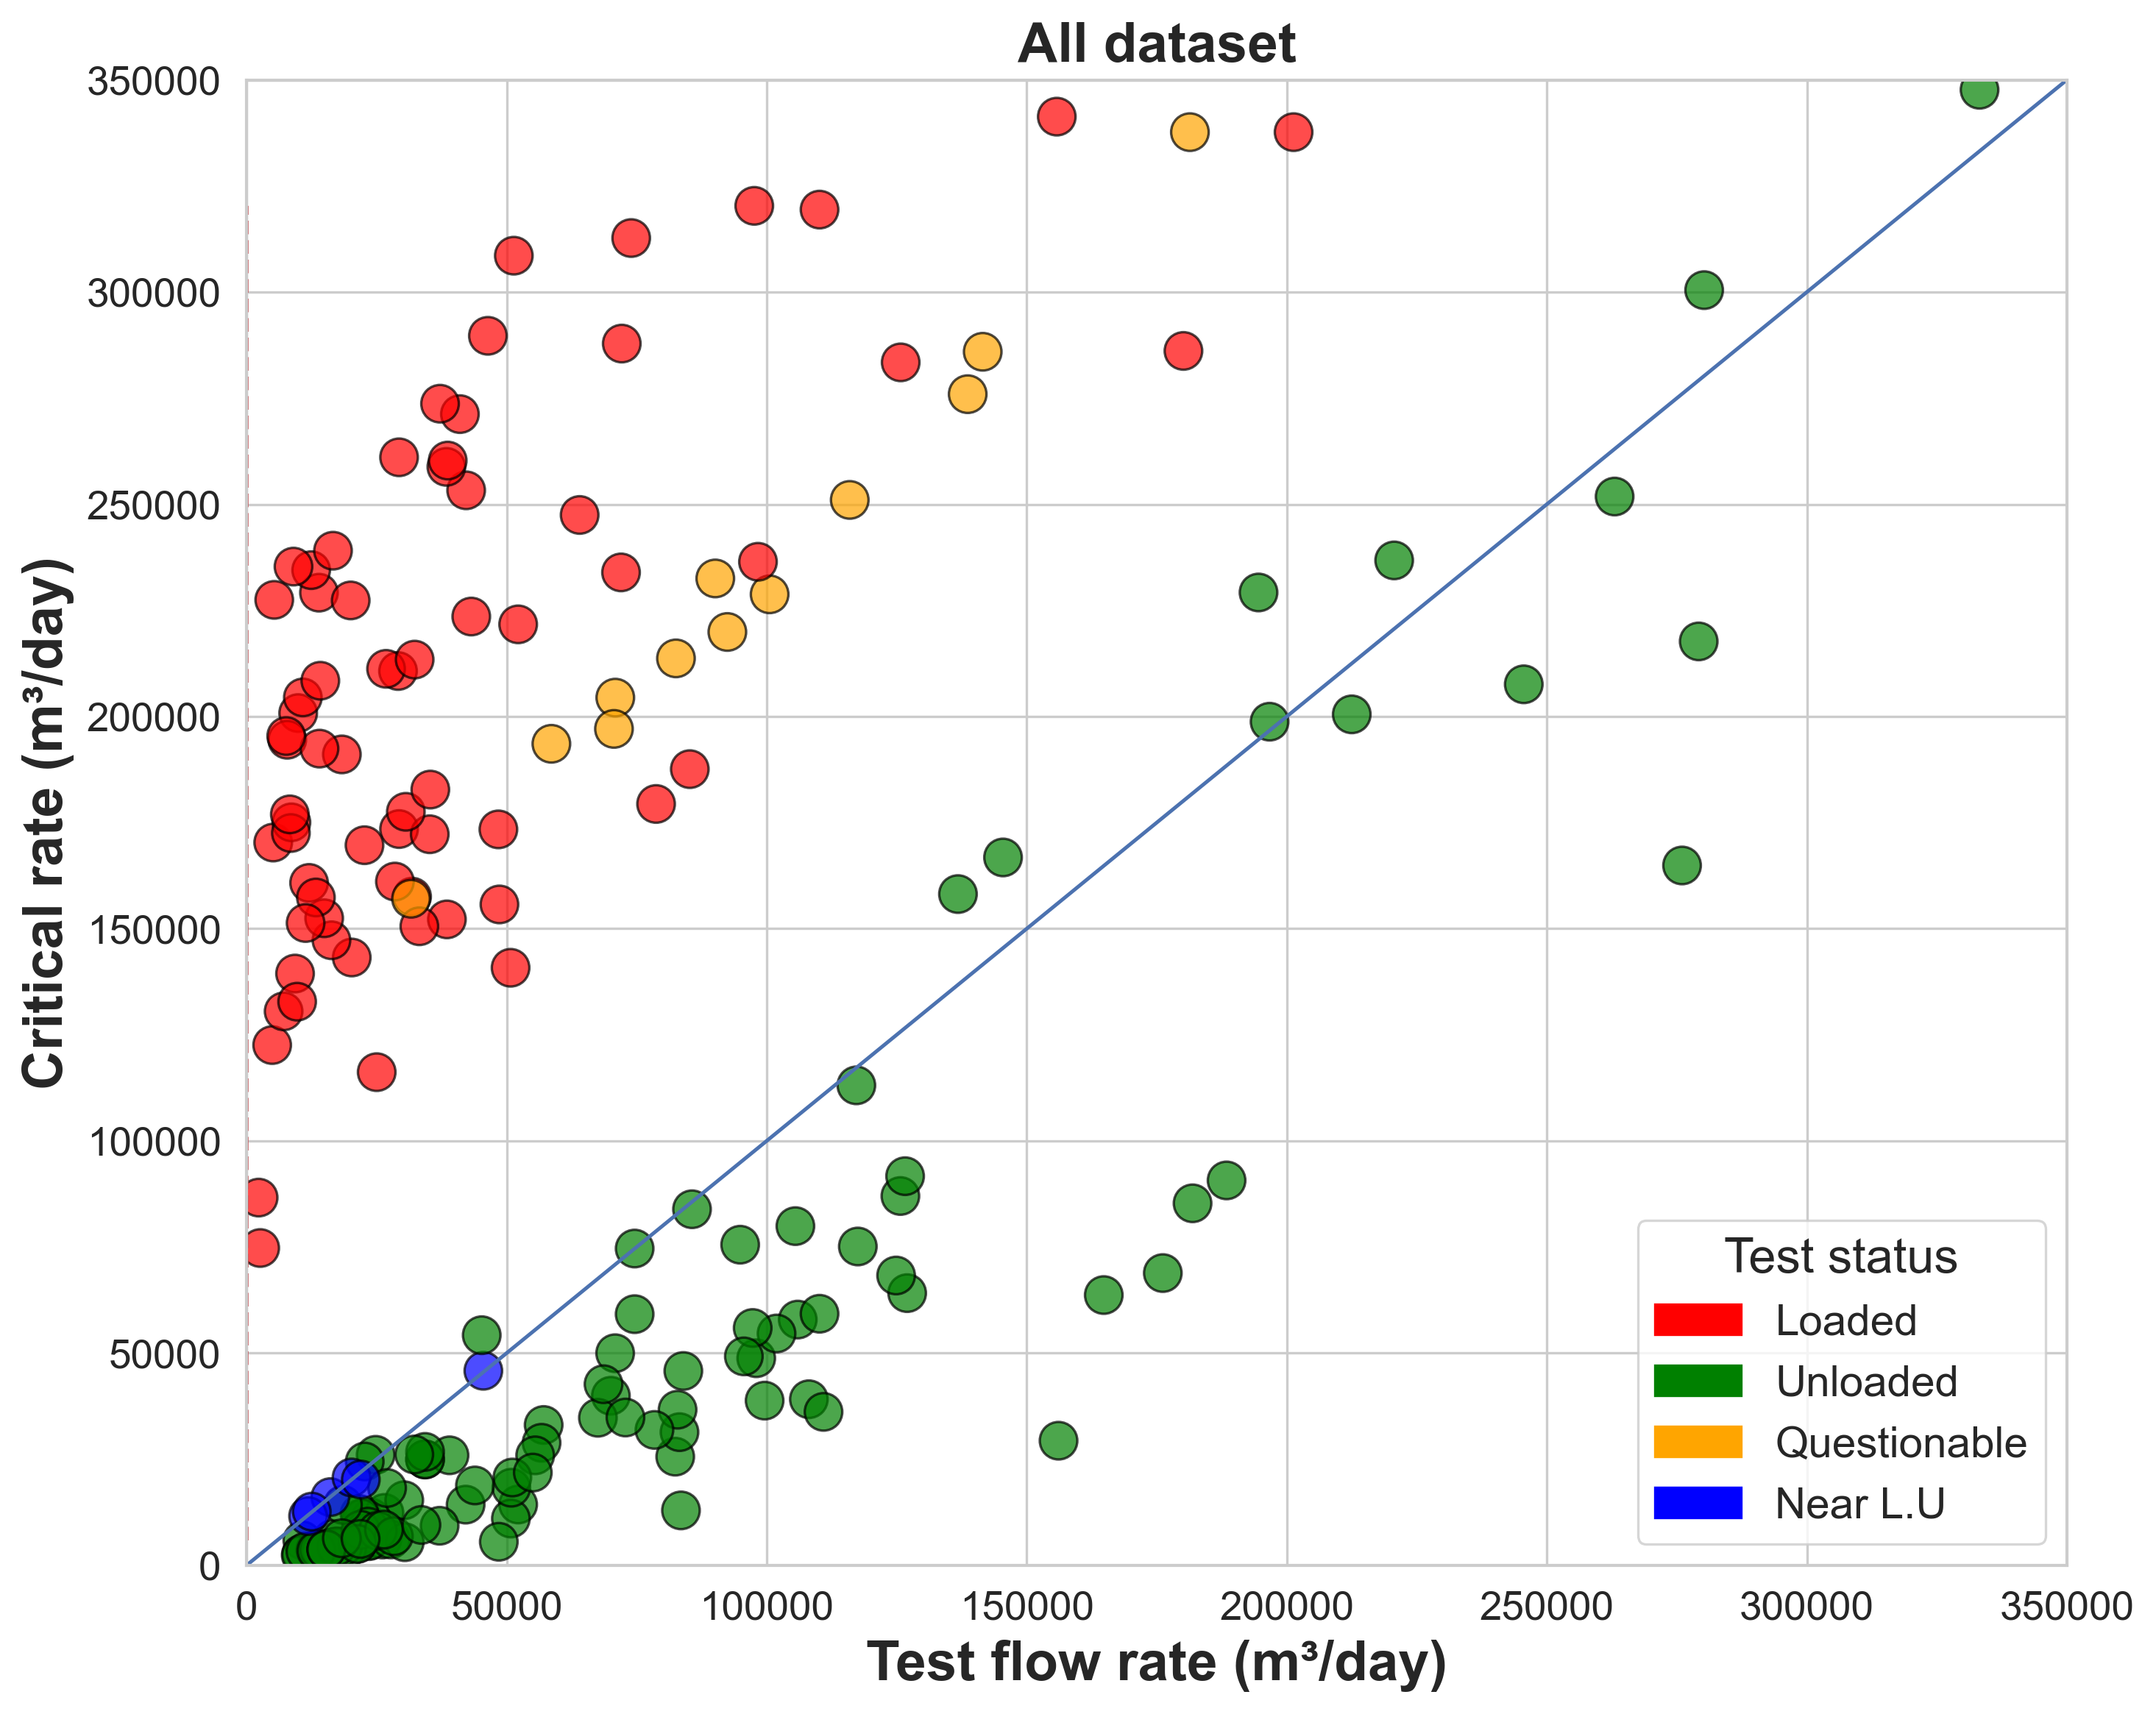

In [8]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Set a high-quality theme for publication
sns.set_theme(style="whitegrid", context="paper", font_scale=1.5)

# Define the color mapping for the "Test status"
color_map = {
    "Loaded": "red",
    "Unloaded": "green",
    "Questionable": "orange",
    "Near L.U": "blue"
}

# Assume Y_pred and df are already defined.
y_pred = predict_y(X, opt_params, dev_train, X_train,
                               alpha_strategy='enhanced_dev_based',
                               multiple_dev_policy=multiple_dev_policy,
                               dev_tol=1e-3, feature_tol=1.0)

# Slice the first 40 entries for plotting.
gasflow_subset = df["Gasflowrate"]
y_pred_subset = y_pred
colors_subset = df['Test status'].map(color_map).fillna("gray")

# Create a high-resolution figure.
plt.figure(figsize=(10, 8), dpi=300)
plt.scatter(gasflow_subset, y_pred_subset, c=colors_subset, alpha=0.7, s = 150, edgecolors="black", label="gplearn Predictions")

plt.plot([0, 350000], [0, 350000], [min(y_pred[:42]), max(y_pred[:42])], '--r')


# Set bold axis labels with increased font sizes.
plt.title("All dataset", fontsize=18, fontweight='bold')
plt.xlabel("Test flow rate (m³/day)", fontsize=18, fontweight='bold')
plt.ylabel("Critical rate (m³/day)", fontsize=18, fontweight='bold')
plt.grid(True)
plt.xlim(0, 350000)
plt.ylim(0, 350000)

# Create legend patches from the color map.
legend_patches = [mpatches.Patch(color=color, label=status) for status, color in color_map.items()]
# legend_patches.append(mpatches.Patch(color="gray", label="Unknown"))
plt.legend(handles=legend_patches, title='Test status', fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.savefig("high_quality_scatter_gao.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()